<img src="files/IntelON_Hackathon_1500x350.png" style="border-radius:15px">

<br>

# <b><div style="color:#211894;font-size:100%;text-align:center">Welcome to the Machine Learning Track of the Hackathon! 🚀</div></b>

## <a id="TOC">Table of Contents</a>
- [1. Introduction](#1)
    - [1.1 Learning Objectives](#1_1)
    - [1.2 Import Libraries and Dataset](#1_2)  
- [2. Exploratory Data Analysis (EDA)](#2)  
    - [2.1 EDA of Numerical Variables](#2_1)
        - [2.1.1 Univariate Distributions](#2_1_1)  
        - [2.1.2 Bivariate Distributions](#2_1_2)
    - [2.2 EDA of Categorical Variables](#2_2)
    - [2.3 Correlations](#2_3)
- [3. Modeling](#3)
    - [3.1 Intel&reg; extension for Scikit-learn](#3_1)
    - [3.2 XGBoost with Intel&reg; daal4py](#3_2)
- [4. Summary](#4)

# <a class="anchor" id="1"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #dc98ff, #251cab)">1 | Introduction</div></a>

In this notebook, we'll introduce the <b>[Predictive Asset Maintenance AI Reference Kit](https://github.com/oneapi-src/predictive-health-analytics)</b> and show you how to use Intel-optimized libraries for machine learning so you can win the Hackathon! The dataset provided in this kit consists of 100,000 different utility poles with over 30 features on the overall health of the utility. Our target variable, <b>`Asset_Label`</b> is a binary indicator, representing whether or not the pole needs to be replaced. Manual problem identifications are less than 50% accurate and the costs of maintenance and replacement of utility poles are over $10 billion. Correctly predicting the probability of a pole replacement will help the company proactively maintain assets and avoid outages, downtime, and operational costs.

## <a class="anchor" id="1_1"><span style="padding:0px;color:#211894;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.1 | Learning Objectives</span></a>
Given the Predictive Asset Maintenance Data, you'll build an end-to-end Machine Learning pipeline using Intel's oneAPI toolkits to optimize the training cycles, prediction throughput, and accuracy. The main libraries we'll be working with in this notebook are the <b>[Intel&reg; Distribution of Modin](https://www.intel.com/content/www/us/en/developer/tools/oneapi/distribution-of-modin.html#gs.9hqdj4)</b>, <b>[Intel&reg; Extension for Scikit-learn](https://www.intel.com/content/www/us/en/developer/tools/oneapi/scikit-learn.html#gs.8txte9)</b>, and <b>[Intel&reg; Daal4py](https://intelpython.github.io/daal4py/)</b>. We'll also demo how to log your model experiments using MLflow and stage your model for deployment, the final step in the pipeline. Then, you'll be ready to apply your skills to the ML Hackathon!

## <a class="anchor" id="1_2"><span style="padding:0px;color:#211894;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.2 | Import Libraries and Dataset</span></a>

In [1]:
import os
import modin.pandas as pd
from modin.config import Engine
os.environ['MODIN_ENGINE'] = 'dask' 
import daal4py as d4p
from xgboost import XGBClassifier
from sklearnex import patch_sklearn

import time
import warnings
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
pio.renderers.default='colab' #'jupyterlab' 
intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

# Read data
data = pandas.read_pickle('files/data_100000.pkl')
print("Data shape: {}\n".format(data.shape))
display(data.head())

Data shape: (100000, 34)



Age  Elevation  Pole_Height  Measured_Length  Number_Repairs  \
0   38       2882    68.779320              694             6.0   
1   13       1215    66.048663              248             5.0   
2   73        248    57.914754             1395             3.0   
3   10        977    76.786475             1940             4.0   
4   76       4186    53.928099              785             3.0   

   Tele_Attached  Asset_Label  Manufacturer_B  Manufacturer_C  Manufacturer_D  \
0              1            0               0               0               0   
1              0            0               0               0               0   
2              1            0               1               0               0   
3              1            0               0               1               0   
4              1            1               0               0               0   

   ...  Species_C3  Species_C4  Species_C5  Species_C6  Species_C7  \
0  ...           0           0           1           0           0   
1  ...           0           0           0           0           0   
2  ...           0           0           0           0           0   
3  ...           0           0           0           0           0   
4  ...           0           0           0           0           1   

   Original_Treatment_Creosote  Original_Treatment_Oil  \
0                            1                       0   
1                            0                       1   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   Original_Treatment_Pentachlorophenol  Original_Treatment_UNK  \
0                                     0                       0   
1                                     0                       0   
2                                     1                       0   
3                                     0                       0   
4                                     0                       1   

   Original_Treatment_Untreated  
0                             0  
1                             0  
2                             0  
3                             1  
4                             0  

[5 rows x 34 columns]

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #251cab, #3eb4f4, #251cab)">2 | Exploratory Data Analysis</div></a>
[Back to Table of contents](#TOC)

<b><span style="color:#211894;font-size:100%;text-align:left">In this section, we'll explore:</span></b>

- Checking for <b><span style="color:#211894;text-align:left">missing values</span></b> and <b><span style="color:#211894;text-align:left">duplicates</span></b> in the dataset.
- Descriptive statistics of the dataset, including the <b><span style="color:#211894;text-align:left">mean</span></b>, <b><span style="color:#211894;text-align:left">min</span></b>, <b><span style="color:#211894;text-align:left">max</span></b>, <b><span style="color:#211894;text-align:left">standard deviation</span></b>, <b><span style="color:#211894;text-align:left">skewness</span></b>, and <b><span style="color:#211894;text-align:left">kurtosis</span></b>.
- The distribution of the target variable, <b>`Asset_Label`</b>.
- <b><span style="color:#211894;text-align:left">Univariate</span></b> and <b><span style="color:#211894;text-align:left">bivariate</span></b> distributions of the numerical and categorical features.
- <b><span style="color:#211894;text-align:left">Correlations</span></b> between the variables in the dataset.

In [2]:
display(data.isna().sum())
missing=data.isna().sum().sum()
duplicates=data.duplicated().sum()
print("\nThere are {:,.0f} missing records in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

Age                                     0
Elevation                               0
Pole_Height                             0
Measured_Length                         0
Number_Repairs                          0
Tele_Attached                           0
Asset_Label                             0
Manufacturer_B                          0
Manufacturer_C                          0
Manufacturer_D                          0
Manufacturer_E                          0
Manufacturer_F                          0
Manufacturer_G                          0
Manufacturer_H                          0
Manufacturer_I                          0
Manufacturer_J                          0
District_N                              0
District_NE                             0
District_NW                             0
District_S                              0
District_SE                             0
District_SW                             0
District_W                              0
Species_C2                        


There are 0 missing records in the data.
There are 0 duplicate records in the data.


At first glance, the dataset appears to be fairly clean with no missing or duplicate records. Let's now look at the descriptive statistics of the dataset. Descriptive statistics provide a numerical summary of the <b><span style="color:#211894;text-align:left">central tendency</span></b>, <b><span style="color:#211894;text-align:left">dispersion</span></b>, and <b><span style="color:#211894;text-align:left">shape</span></b> of the data's distribution, excluding `NaN` values.

In [3]:
def display_stats(df):
    
    """
    Function to display descriptive statistics of numerical variables,
    includes skewness & kurtosis.   
    """
    
    df=data.describe()
    skewness=data.skew()
    kurtosis=data.kurtosis()
    df=df.append([skewness, kurtosis],ignore_index=True)
    idx=pd.Series(['count','mean','std','min','25%','50%','75%','max','skewness','kurtosis'],name='Summary Statistic')
    df=pd.concat([df,idx],1).set_index('Summary Statistic')
    display(df.style.format('{:,.3f}').
        background_gradient(subset=(df.index[1:],df.columns[:]),
                            cmap='GnBu'))

display_stats(data)

In [4]:
def plot_target_dist(target_col):
    
    """Function to display distribution of the target variable"""
    
    target=data[target_col].value_counts(normalize=True)
    target.rename(index={1:'State 1',0:'State 0'},inplace=True)
    fig=go.Figure()
    fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                         text=target.index, sort=False, showlegend=False,
                         marker=dict(colors=color,line=dict(color=intel_pal,width=2.5)),
                         hovertemplate = "%{label}: <b>%{value:.2f}%</b><extra></extra>"))
    fig.update_layout(template=temp, title='Target Distribution',width=700,height=450,
                      uniformtext_minsize=15, uniformtext_mode='hide')
    fig.write_image("files/fig1.svg")
    fig.show() 
    
plot_target_dist(target_col='Asset_Label')

<img src="files/fig1.svg">

About 40% of poles in our data have been identified as needing to be replaced, State 1. Given the imbalance in the distribution of our target variable, we may want to use <b><span style="color:#211894;text-align:left">stratified sampling</span></b> during cross-validation.

### <a class="anchor" id="2_1"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #009ff2, #251cab)">2.1 | EDA of Numerical Variables</div></a>

[Back to Table of Contents](#TOC)

<br>

<b><a class="anchor" id="2_1_1"><span style="padding:0px;color:#211894;margin:0;font-size:120%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">2.1.1 | Univariate Distributions</span></a></b>

Now that we have a better understanding of the target distribution, let's take a closer look at the features in the dataset to identify any patterns. The graphs below show the Kernel Density Estimation (KDE) plots of the numerical variables, which visually display the shape of the data using its probability density function.

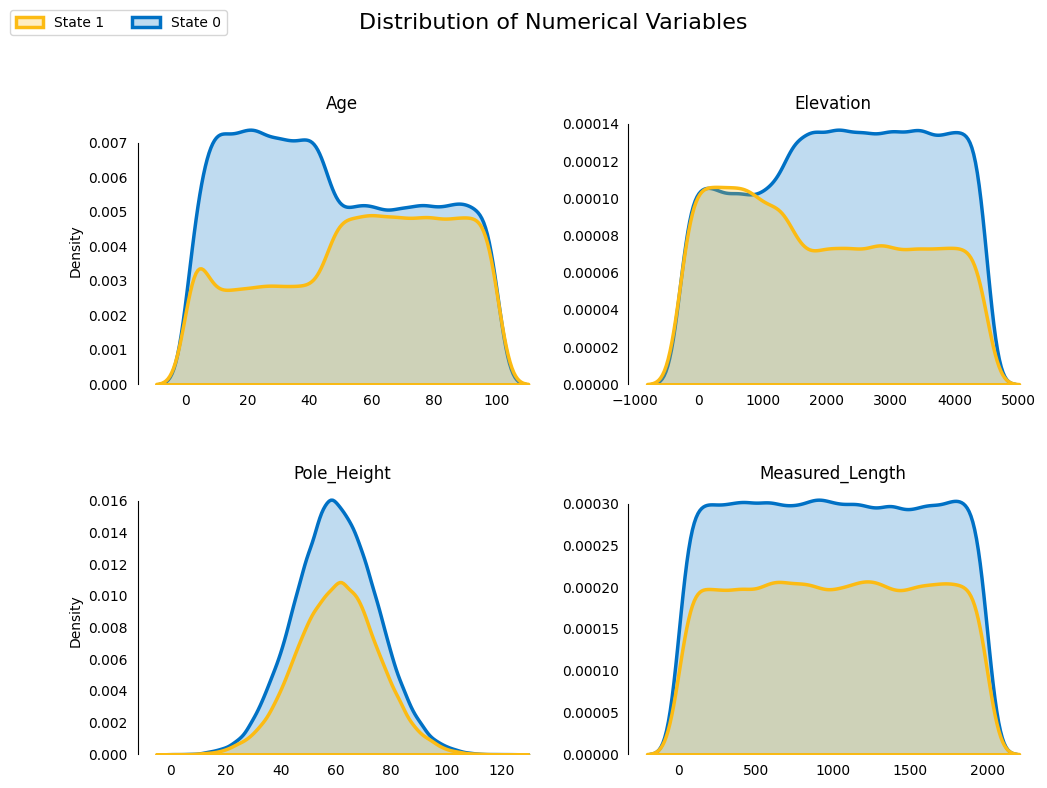

In [5]:
cat_cols,float_cols=[],['Asset_Label']
for col in data.columns:
    if data[col].value_counts().count()<10:
        cat_cols.append(col)
    else:
        float_cols.append(col)
        
plot_df=data[float_cols]
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Distribution of Numerical Variables',fontsize=16)
row=0
col=[0,1]*2
for i, column in enumerate(plot_df.columns[1:]):
    if (i!=0)&(i%2==0):
        row+=1
    sns.kdeplot(x=column, hue='Asset_Label', palette=intel_pal[::-1], hue_order=[1,0], 
                label=['State 1','State 0'], data=plot_df, 
                fill=True, linewidth=2.5, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False, bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%2==0 else ''))

handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['State 1','State 0'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.99))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In the graphs above, we see the variable `Pole_Height` has a bell-shaped curve following a normal distribution, while the remaining variables more closely resemble uniform, non-normal distributions.

<b><a class="anchor" id="2_1_2"><span style="padding:0px;color:#211894;margin:0;font-size:120%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">2.1.2 | Bivariate Distributions</span></a></b>

In [6]:
fig=make_subplots(rows=2,cols=2, subplot_titles=float_cols[1:])
col=[1,2]*2
row=0
pal=sns.color_palette("GnBu",20).as_hex()[9:][::3]
for i, column in enumerate(data[float_cols].columns[1:]):
    if i%2==0:
        row+=1
    df = pd.concat([data[column],data['Asset_Label']],axis=1)
    df['bins'] = pd.cut(df[column],300)
    df['mean'] = df.bins.apply(lambda x: x.mid)
    df = df.groupby('mean')[column,'Asset_Label'].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    fig.add_trace(go.Scatter(x=df[column], y=df.Asset_Label, name=column,
                             marker_color=pal[i],showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%2==0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i])
fig.update_layout(template=temp, title='Feature Relationships with Target', 
                  hovermode="x unified",height=700,width=900)
fig.write_image("files/fig2.svg")
fig.show()

<img src="files/fig2.svg">

To identify the relationships between the target variable and the continuous features, the graphs above depict the target probability across the values in each feature. In `Age`, we see the probability tends to be higher in poles that are above about 45 years and less than 5 years, while in `Elevation` this is true for poles that are below about 1000 feet. In addition, we see there are non-linear relationships between the target and the features, which suggests we may want to try a nonparametric model. This is further demonstrated in the scatterplot matrix below, where we see very weak linearity and correlations between the numerical features in the data.

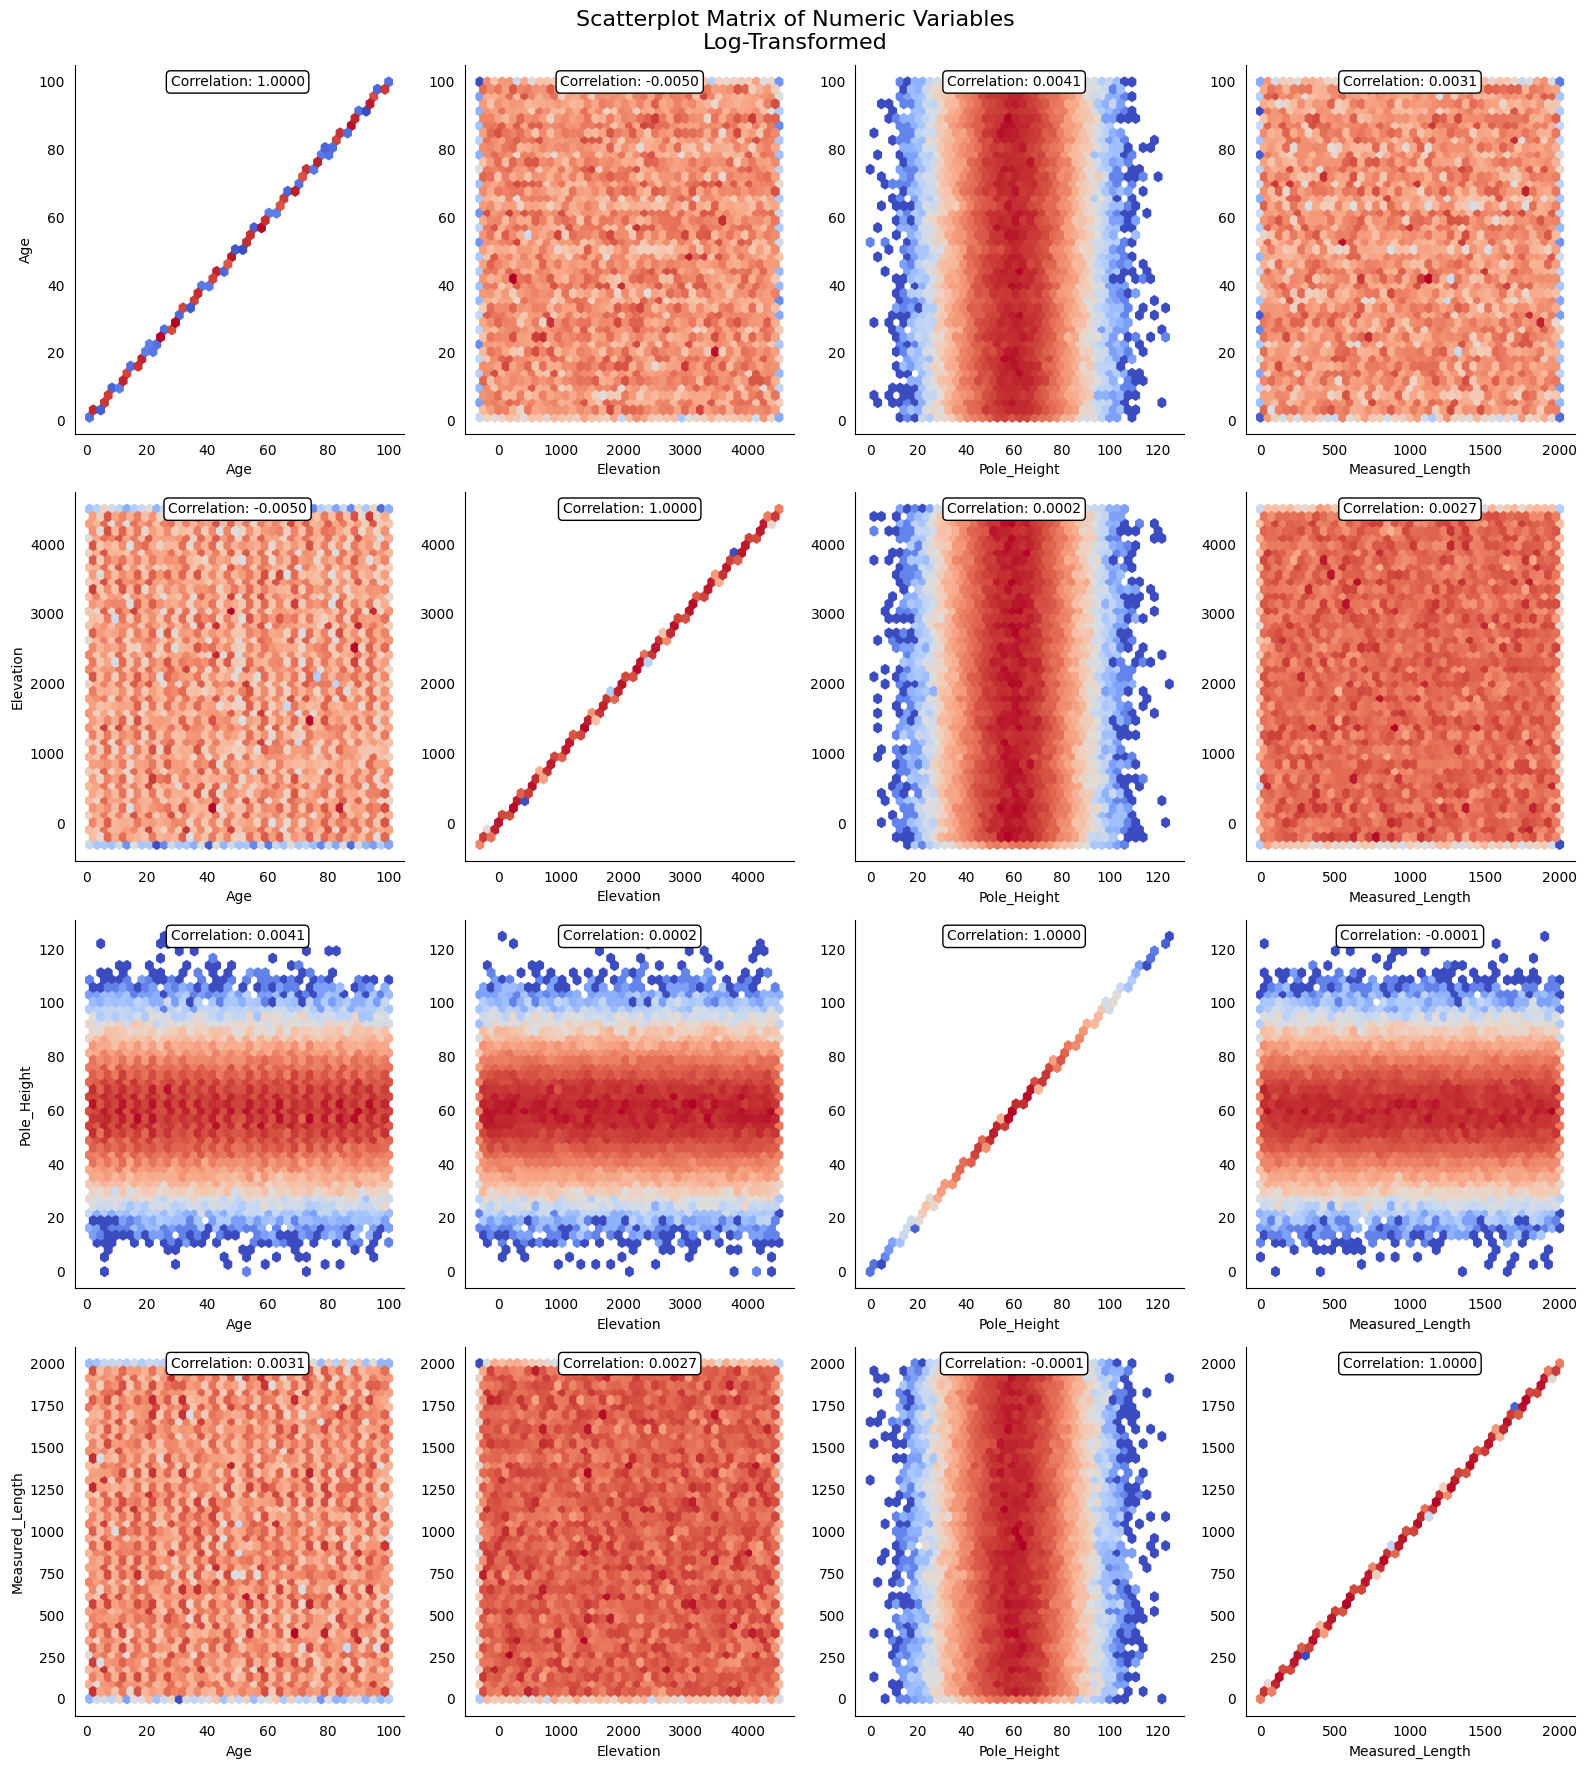

In [6]:
plot_df=data[float_cols]
fig, ax = plt.subplots(4,4, figsize=(16,18))
fig.suptitle('Scatterplot Matrix of Numeric Variables\nLog-Transformed',fontsize=16)
for i, col in enumerate(float_cols[1:]):
    for j, iter_col in enumerate(float_cols[1:]):
        ax[i,j].hexbin(x=iter_col, y=col, data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
        ax[i,j].set(xlabel=iter_col, ylabel=(col if j%4==0 else ''))
        ax[i,j].text(plot_df[iter_col].median(), plot_df[col].max(), 
                     'Correlation: {:.4f}'.format(plot_df[[col,iter_col]].corr().iloc[1,0]), 
                   ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
        ax[i,j].tick_params(left=False,bottom=False)    
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

### <a class="anchor" id="2_2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #009ff2, #251cab)">2.2 | EDA of Categorical Variables</div></a>

[Back to Table of Contents](#TOC)

Now that we have explored our numerical variables, let's take a look at the distributions in the categorical features. The categorical features in the dataset have already been preprocessed to qualitatively represent the presence or absence of the variable with a corresponding 1 or 0, known as one-hot encoding. The graphs below show the frequency of the occurrence of each feature, colored by the target label. 

In [7]:
fig = make_subplots(rows=10, cols=3, subplot_titles=[c for c in cat_cols if c!='Asset_Label'])
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.6)) for i in intel_pal]
row=0
c=[1,2,3]*10
for i, col in enumerate(c for c in cat_cols if c!='Asset_Label'):
    if i%3==0:
        row+=1
    df=data.groupby(col)['Asset_Label'].value_counts().rename('count').reset_index()
    fig.add_trace(go.Bar(x=df[df.Asset_Label==1][col], y=df[df.Asset_Label==1]['count'],width=.35,
                         marker_color=rgb[1], marker_line=dict(color=intel_pal[1],width=2.5), 
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 1', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=df[df.Asset_Label==0][col], y=df[df.Asset_Label==0]['count'],width=.35,
                         marker_color=rgb[0], marker_line=dict(color=intel_pal[0],width=2.5),
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 0', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%3==0:
        fig.update_yaxes(title='Frequency',row=row,col=c[i])
fig.update_layout(template=temp,title="Distributions of Categorical Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.025,xanchor="right",x=.2),
                  barmode='group',height=2000,width=900)
fig.write_image("files/fig3.svg")
fig.show()

<img src="files/fig3.svg">

### <a class="anchor" id="2_3"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #009ff2, #251cab)">2.3 | Correlations</div></a>

[Back to Table of Contents](#TOC)

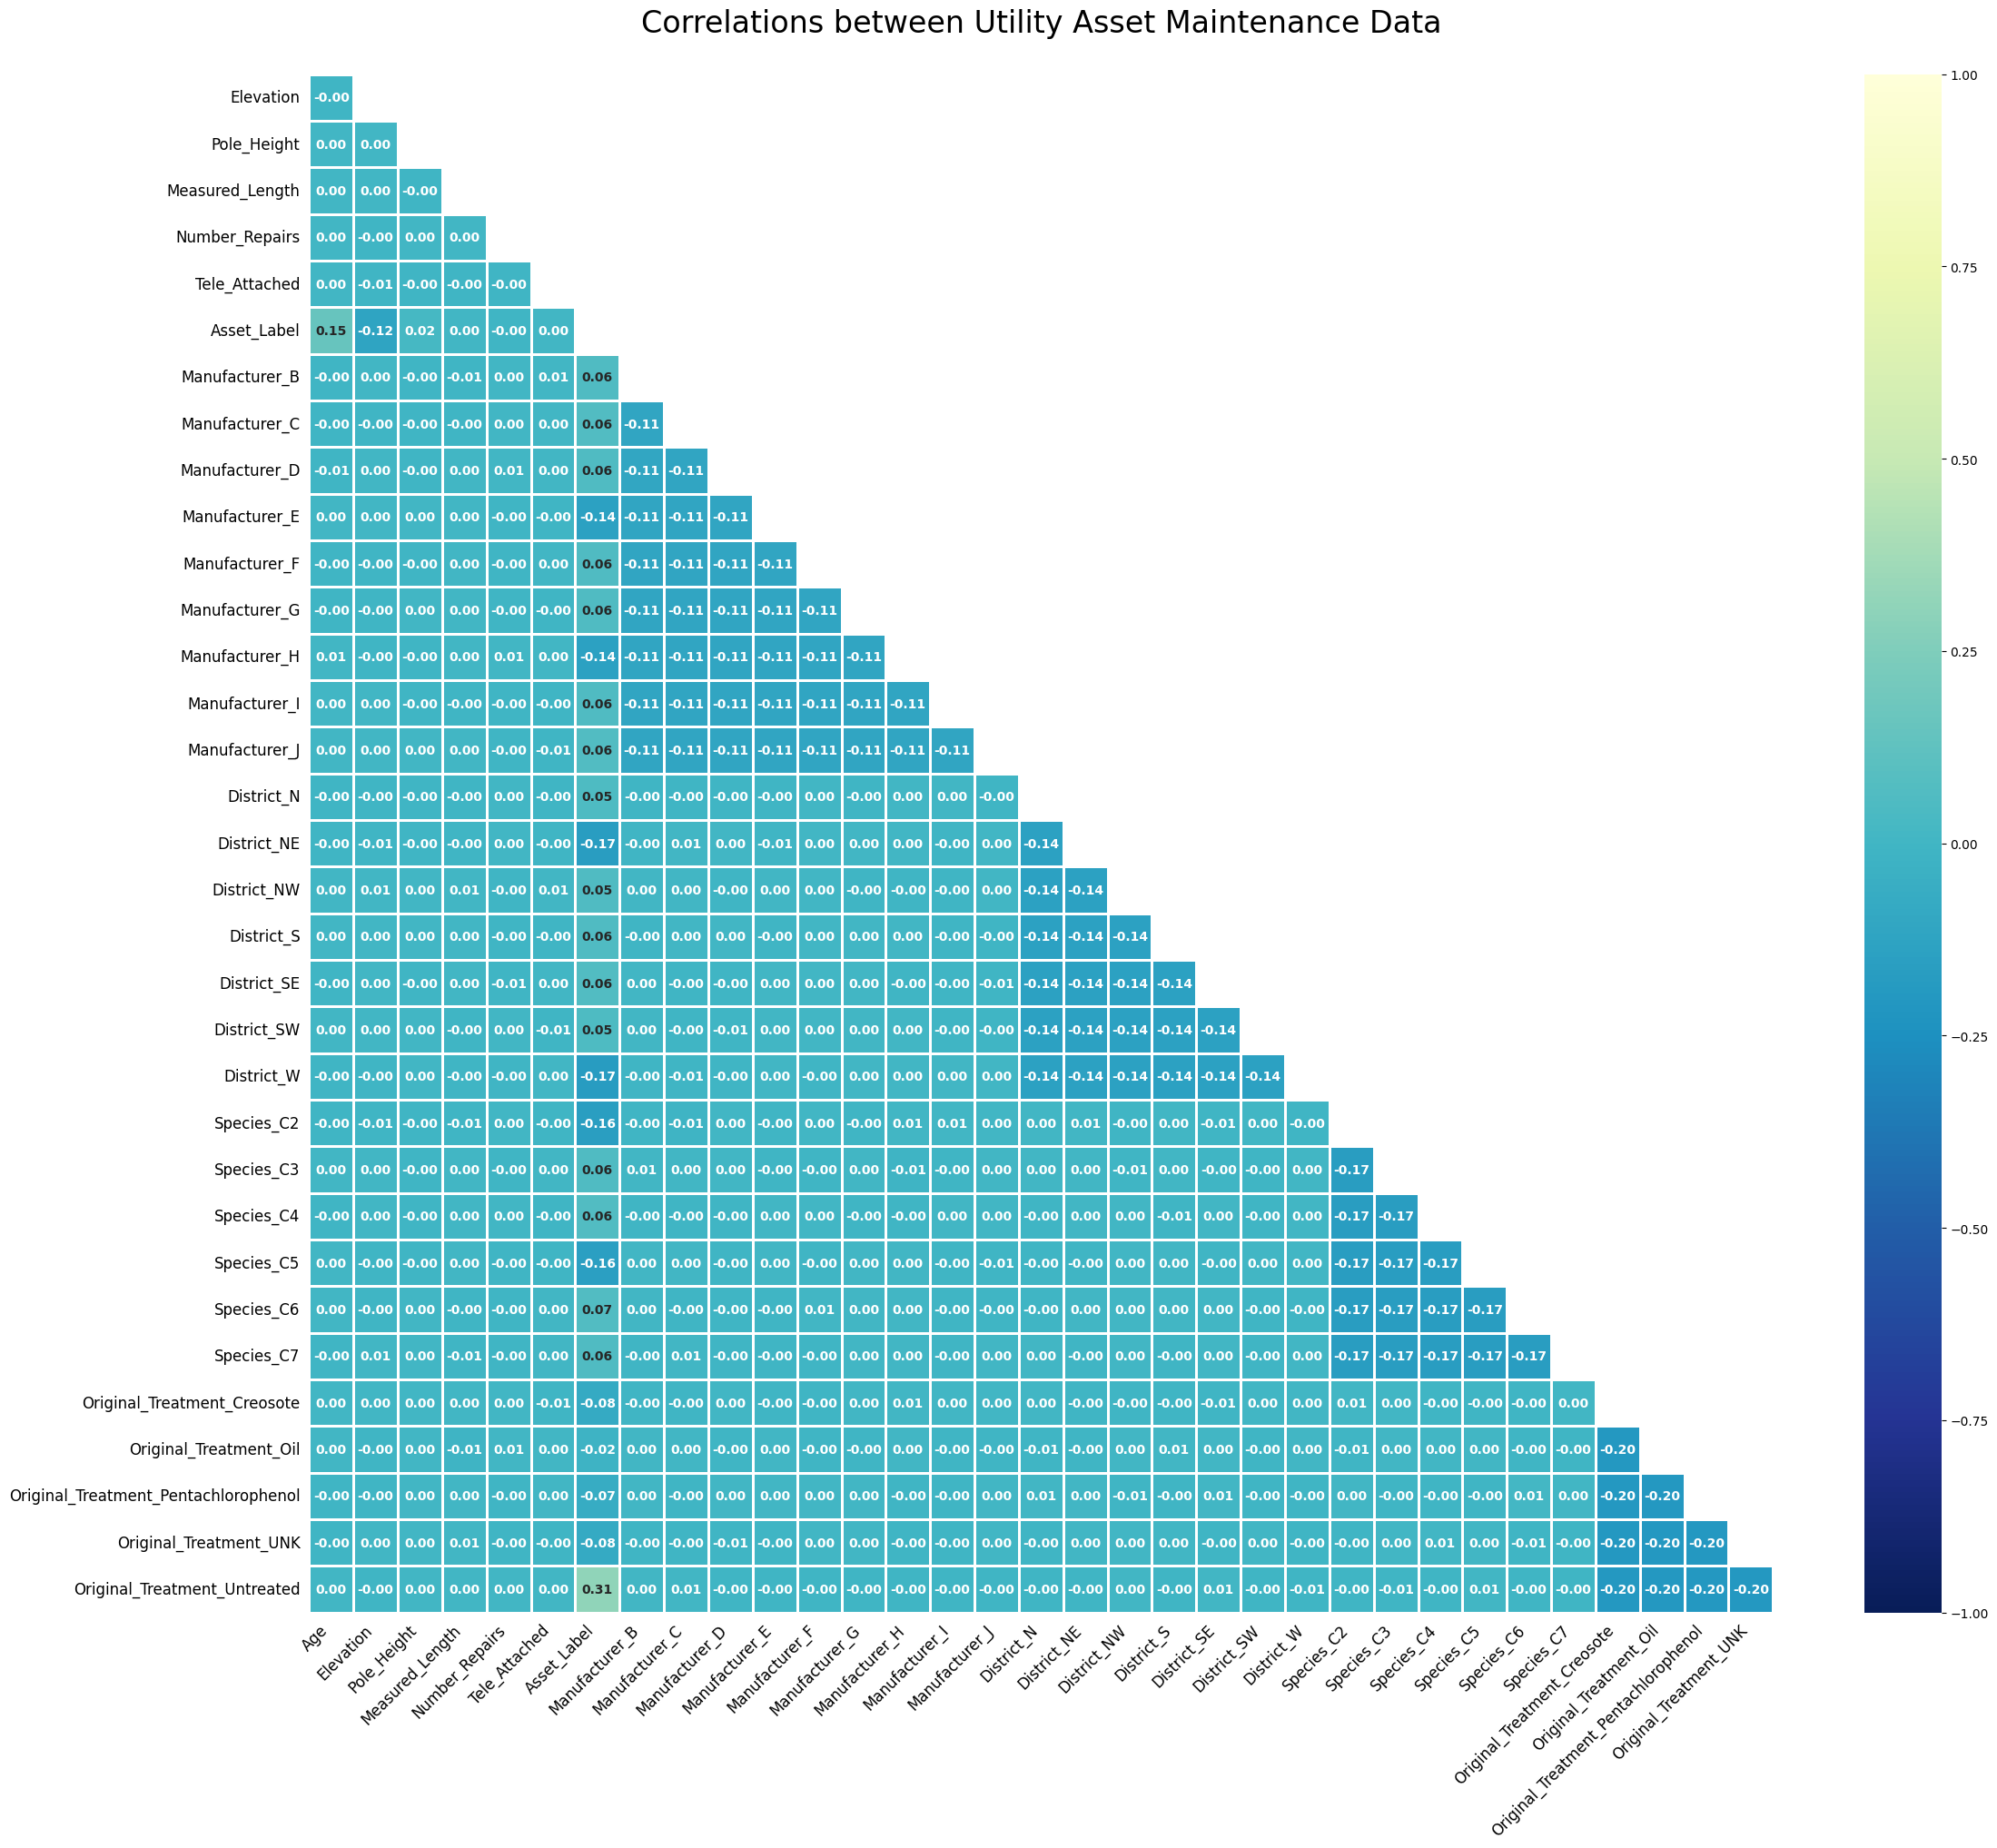

In [8]:
def plot_corr(corr):
    """
    Function to plot bottom left triangle of correlation matrix
    """
    mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
    corr=corr.iloc[1:,:-1].copy()
    fig, ax = plt.subplots(figsize=(26,22))   
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
                cmap='YlGnBu_r',lw=2, annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=True)
    ax.tick_params(left=False,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
    plt.title('Correlations between Utility Asset Maintenance Data\n', fontsize=24)
    plt.show()
    
def plot_target_corr(corr, target_col): 
    """
    Function to plot a bar chart of correlations between target and features, sorted in descending order
    """
    corr=corr[target_col].sort_values(ascending=False)[1:]
    pal=sns.color_palette("RdYlBu",37).as_hex()
    pal=[j for i,j in enumerate(pal) if i not in (17,18)]
    rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
    
    fig=go.Figure()
    fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                         marker_line=dict(color=pal,width=2),
                         hovertemplate='%{x} correlation with Target = %{y}',
                         showlegend=False, name=''))
    fig.update_layout(template=temp, title='Feature Correlations with Target (Asset Label)', 
                      yaxis_title='Correlation', margin=dict(b=160), xaxis_tickangle=45)
    fig.write_image("files/fig4.svg")
    fig.show()
    
corr=data.corr()
plot_corr(corr=corr)
plot_target_corr(corr=corr, target_col='Asset_Label')

<img src="files/fig4.svg">

As we saw in the scatterplot matrix above, there were very low correlations among the numerical features, which also remains true between the rest of the features in the dataset. Among our target variable, `Asset_Label`, the highest positive association exists with `Original_Treatment_Untreated` at 0.311 and the strongest negative relationship between `District_W` at -0.172

# <a class="anchor" id="3"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #3eb4f4, #251cab)">3 | Modeling</div></a>

[Back to Table of Contents](#TOC)

In [9]:
def prepare_train_test_data(data, target_col, test_size):
    
    """
    Function to scale and split the data into training and test sets
    """
    
    scaler = RobustScaler()   
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=21)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Train Shape: {}".format(X_train_scaled.shape))
    print("Test Shape: {}".format(X_test_scaled.shape))
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def plot_model_res(model_name, y_test, y_prob):
    
    """
    Function to plot ROC/PR Curves and predicted target distribution
    """
    
    intel_pal=['#0071C5','#FCBB13']
    color=['#7AB5E1','#FCE7B2']
    
    ## ROC & PR Curve ##
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auprc = average_precision_score(y_test, y_prob)
    
    fig = make_subplots(rows=1, cols=2, 
                        shared_yaxes=True, 
                        subplot_titles=['Receiver Operating Characteristic<br>(ROC) Curve',
                                        'Precision-Recall Curve<br>AUPRC = {:.3f}'.format(auprc)])
    
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Baseline',mode='lines',legendgroup=1,
                             line=dict(color="Black", width=1, dash="dot")), row=1,col=1)    
    fig.add_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=intel_pal[0], width=3), 
                             hovertemplate = 'True positive rate = %{y:.3f}, False positive rate = %{x:.3f}',
                             name='AUC = {:.4f}'.format(roc_auc),legendgroup=1), row=1,col=1)
    fig.add_trace(go.Scatter(x=recall, y=precision, line=dict(color=intel_pal[0], width=3), 
                             hovertemplate = 'Precision = %{y:.3f}, Recall = %{x:.3f}',
                             name='AUPRC = {:.4f}'.format(auprc),showlegend=False), row=1,col=2)
    fig.update_layout(template=temp, title="{} ROC and Precision-Recall Curves".format(model_name), 
                      hovermode="x unified", width=900,height=500,
                      xaxis1_title='False Positive Rate (1 - Specificity)',
                      yaxis1_title='True Positive Rate (Sensitivity)',
                      xaxis2_title='Recall (Sensitivity)',yaxis2_title='Precision (PPV)',
                      legend=dict(orientation='v', y=.07, x=.45, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.write_image("files/{}_ROC_PRCurve.svg".format(model_name))
    fig.show()
    
    ## Target Distribution ##     
    plot_df=pd.DataFrame.from_dict({'State 0':(len(y_prob[y_prob<=0.5])/len(y_prob))*100, 
                                    'State 1':(len(y_prob[y_prob>0.5])/len(y_prob))*100}, 
                                   orient='index', columns=['pct'])
    fig=go.Figure()
    fig.add_trace(go.Pie(labels=plot_df.index, values=plot_df.pct, hole=.45, 
                         text=plot_df.index, sort=False, showlegend=False,
                         marker=dict(colors=color,line=dict(color=intel_pal,width=2.5)),
                         hovertemplate = "%{label}: <b>%{value:.2f}%</b><extra></extra>"))
    fig.update_layout(template=temp, title='Predicted Target Distribution',width=700,height=450,
                      uniformtext_minsize=15, uniformtext_mode='hide')
    fig.write_image("files/{}_Predictions.svg".format(model_name))
    fig.show()

## <b><a class="anchor" id="3_1"><span style="padding:0px;color:#211894;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.1 | Support Vector Classifier with Intel&reg; Extension for Scikit-learn</span></a></b>

[Back to Table of Contents](#TOC)

In [10]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
## Prepare Train and Test datasets ##
print("Preparing Train and Test datasets")
X_train, X_test, y_train, y_test = prepare_train_test_data(data=data,
                                                           target_col='Asset_Label', 
                                                           test_size=.25)
## Initialize SVC model ##
parameters = {
    'class_weight': 'balanced',
    'probability': True,
    'random_state': 21}
svc = SVC(**parameters)

## Tune Hyperparameters ##
strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
print("\nTuning hyperparameters..")
grid = {
    #'C': [1e-3, 1e-2, 0.1, 1, 10],
    'kernel': ['linear', 'poly'] #'rbf', 'sigmoid']
    }
grid_search = GridSearchCV(svc, param_grid=grid, 
                           cv=strat_kfold, scoring='roc_auc', 
                           verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Done!\nBest hyperparameters:", grid_search.best_params_)
print("Best cross-validation AUC: {:.4f}".format(grid_search.best_score_))

svc = grid_search.best_estimator_
svc_prob = svc.predict_proba(X_test)[:,1]
svc_pred = svc.predict(X_test)
svc_f1 = f1_score(y_test, svc_pred)
svc_auc = roc_auc_score(y_test, svc_prob)
    
## Print model results ##
print("\nTest F1 accuracy: {:.2f}%, AUC: {:.5f}".format(svc_f1*100,svc_auc))
plot_model_res(model_name='SVC', y_test=y_test, y_prob=svc_prob)

Preparing Train and Test datasets
Train Shape: (75000, 33)
Test Shape: (25000, 33)

Tuning hyperparameters..
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Done!
Best hyperparameters: {'kernel': 'poly'}
Best cross-validation AUC: 0.9041

Test F1 accuracy: 85.19%, AUC: 0.90825


## <b><a class="anchor" id="3_2"><span style="padding:0px;color:#211894;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.2 | XGBoost</span></a></b>
[Back to Table of Contents](#TOC)

In [16]:
## Prepare Train and Test datasets ##
print("Preparing Train and Test datasets")
X_train, X_test, y_train, y_test = prepare_train_test_data(data=data,
                                                           target_col='Asset_Label', 
                                                           test_size=.25)

## Initialize XGBoost model ##
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
parameters = {'scale_pos_weight': ratio.round(2), 
              'tree_method': 'hist',
              'random_state': 21}
xgb_model = XGBClassifier(**parameters)

## Tune hyperparameters ##
strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
print("\nTuning hyperparameters..")
grid = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        #'learning_rate': [0.001, 0.01]
        }

grid_search = GridSearchCV(xgb_model, param_grid=grid, 
                           cv=strat_kfold, scoring='roc_auc', 
                           verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Done!\nBest hyperparameters:", grid_search.best_params_)
print("Best cross-validation AUC: {:.4f}".format(grid_search.best_score_))

Preparing Train and Test datasets
Train Shape: (75000, 33)
Test Shape: (25000, 33)

Tuning hyperparameters..
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Done!
Best hyperparameters: {'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5}
Best cross-validation AUC: 0.9380


### <b><a class="anchor" id="3_2"><span style="padding:0px;color:#211894;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.2.1 | XGBoost Inference with Intel&reg; Daal4py</span></a></b>

In [17]:
## Convert to daal4py ##
xgb=grid_search.best_estimator_
daal_model = d4p.get_gbt_model_from_xgboost(xgb.get_booster())
daal_prob = d4p.gbt_classification_prediction(nClasses=2,
    resultsToEvaluate="computeClassLabels|computeClassProbabilities",
    fptype='float').compute(X_test, daal_model).probabilities
xgb_auc = roc_auc_score(y_test, daal_prob[:,1])
xgb_pred = np.where(daal_prob[:,1]>.5, 1, 0)
xgb_f1 = f1_score(y_test, xgb_pred)   

## Plot model results ##
print("\nTest F1 Accuracy: {:.2f}%, AUC: {:.5f}".format(xgb_f1*100, xgb_auc)) 
plot_model_res(model_name='XGBoost', y_test=y_test, y_prob=daal_prob[:,1])


Test F1 Accuracy: 90.15%, AUC: 0.94006


<img src="files/XGBoost_ROC_PRCurve.svg">
<img src="files/XGBoost_Predictions.svg">

# <a class="anchor" id="4"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(90deg, navy, #3eb4f4, #251cab)">4 | Summary</div></a>
[Back to Table of Contents](#TOC)